In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import time
import math
import torch
import torch.utils
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.nn.parameter import Parameter
from os.path import join as pjoin

In [2]:
# Experiment parameters
batch_size = 32
threads = 0
lr = 0.005
epochs = 40
log_interval = 10
wdecay = 1e-4
dataset = 'proteins'
model_name = 'unet'  # 'gcn', 'unet'
device = 'cpu'  # 'cuda', 'cpu'
visualize = True
shuffle_nodes = False
n_folds = 10  # 10-fold cross validation
seed = 111
print('torch', torch.__version__)

torch 0.4.1


In [3]:
# Data loader and reader
class GraphData(torch.utils.data.Dataset):
    def __init__(self,
                 datareader,
                 fold_id,
                 split):
        self.fold_id = fold_id
        self.split = split
        self.rnd_state = datareader.rnd_state
        self.set_fold(datareader.data, fold_id)

    def set_fold(self, data, fold_id):
        self.total = len(data['targets'])
        self.N_nodes_max = data['N_nodes_max']
        self.n_classes = data['n_classes']
        self.features_dim = data['features_dim']
        self.idx = data['splits'][fold_id][self.split]
         # use deepcopy to make sure we don't alter objects in folds
        self.labels = copy.deepcopy([data['targets'][i] for i in self.idx])
        self.adj_list = copy.deepcopy([data['adj_list'][i] for i in self.idx])
        self.features_onehot = copy.deepcopy([data['features_onehot'][i] for i in self.idx])
        print('%s: %d/%d' % (self.split.upper(), len(self.labels), len(data['targets'])))
        self.indices = np.arange(len(self.idx))  # sample indices for this epoch
        
    def pad(self, mtx, desired_dim1, desired_dim2=None, value=0):
        sz = mtx.shape
        assert len(sz) == 2, ('only 2d arrays are supported', sz)
        # if np.all(np.array(sz) < desired_dim1 / 3): print('matrix shape is suspiciously small', sz, desired_dim1)
        if desired_dim2 is not None:
            mtx = np.pad(mtx, ((0, desired_dim1 - sz[0]), (0, desired_dim2 - sz[1])), 'constant', constant_values=value)
        else:
            mtx = np.pad(mtx, ((0, desired_dim1 - sz[0]), (0, 0)), 'constant', constant_values=value)
        return mtx
    
    def nested_list_to_torch(self, data):
        if isinstance(data, dict):
            keys = list(data.keys())           
        for i in range(len(data)):
            if isinstance(data, dict):
                i = keys[i]
            if isinstance(data[i], np.ndarray):
                data[i] = torch.from_numpy(data[i]).float()
            elif isinstance(data[i], list):
                data[i] = list_to_torch(data[i])
        return data
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        index = self.indices[index]
        N_nodes_max = self.N_nodes_max
        N_nodes = self.adj_list[index].shape[0]
        graph_support = np.zeros(self.N_nodes_max)
        graph_support[:N_nodes] = 1
        return self.nested_list_to_torch([self.pad(self.features_onehot[index].copy(), self.N_nodes_max),  # node_features
                                          self.pad(self.adj_list[index], self.N_nodes_max, self.N_nodes_max),  # adjacency matrix
                                          graph_support,  # mask with values of 0 for dummy (zero padded) nodes, otherwise 1 
                                          N_nodes,
                                          int(self.labels[index])])  # convert to torch


class DataReader():
    '''
    Class to read the txt files containing all data of the dataset
    '''
    def __init__(self,
                 data_dir,  # folder with txt files
                 rnd_state=None,
                 use_cont_node_attr=False,  # use or not additional float valued node attributes available in some datasets
                 folds=10):

        self.data_dir = data_dir
        self.rnd_state = np.random.RandomState() if rnd_state is None else rnd_state
        self.use_cont_node_attr = use_cont_node_attr
        files = os.listdir(self.data_dir)
        data = {}
        nodes, graphs = self.read_graph_nodes_relations(list(filter(lambda f: f.find('graph_indicator') >= 0, files))[0])
        data['features'] = self.read_node_features(list(filter(lambda f: f.find('node_labels') >= 0, files))[0], 
                                                 nodes, graphs, fn=lambda s: int(s.strip()))  
        data['adj_list'] = self.read_graph_adj(list(filter(lambda f: f.find('_A') >= 0, files))[0], nodes, graphs)                      
        data['targets'] = np.array(self.parse_txt_file(list(filter(lambda f: f.find('graph_labels') >= 0, files))[0],
                                                       line_parse_fn=lambda s: int(float(s.strip()))))
        
        if self.use_cont_node_attr:
            data['attr'] = self.read_node_features(list(filter(lambda f: f.find('node_attributes') >= 0, files))[0], 
                                                   nodes, graphs, fn=lambda s: np.array(list(map(float, s.strip().split(',')))))
        
        features, n_edges, degrees = [], [], []
        for sample_id, adj in enumerate(data['adj_list']):
            N = len(adj)  # number of nodes
            if data['features'] is not None:
                assert N == len(data['features'][sample_id]), (N, len(data['features'][sample_id]))
            n = np.sum(adj)  # total sum of edges
            assert n % 2 == 0, n
            n_edges.append( int(n / 2) )  # undirected edges, so need to divide by 2
            if not np.allclose(adj, adj.T):
                print(sample_id, 'not symmetric')
            degrees.extend(list(np.sum(adj, 1)))
            features.append(np.array(data['features'][sample_id]))
                        
        # Create features over graphs as one-hot vectors for each node
        features_all = np.concatenate(features)
        features_min = features_all.min()
        features_dim = int(features_all.max() - features_min + 1)  # number of possible values
        
        features_onehot = []
        for i, x in enumerate(features):
            feature_onehot = np.zeros((len(x), features_dim))
            for node, value in enumerate(x):
                feature_onehot[node, value - features_min] = 1
            if self.use_cont_node_attr:
                feature_onehot = np.concatenate((feature_onehot, np.array(data['attr'][i])), axis=1)
            features_onehot.append(feature_onehot)

        if self.use_cont_node_attr:
            features_dim = features_onehot[0].shape[1]
            
        shapes = [len(adj) for adj in data['adj_list']]
        labels = data['targets']        # graph class labels
        labels -= np.min(labels)        # to start from 0
        N_nodes_max = np.max(shapes)    

        classes = np.unique(labels)
        n_classes = len(classes)

        if not np.all(np.diff(classes) == 1):
            print('making labels sequential, otherwise pytorch might crash')
            labels_new = np.zeros(labels.shape, dtype=labels.dtype) - 1
            for lbl in range(n_classes):
                labels_new[labels == classes[lbl]] = lbl
            labels = labels_new
            classes = np.unique(labels)
            assert len(np.unique(labels)) == n_classes, np.unique(labels)

        print('N nodes avg/std/min/max: \t%.2f/%.2f/%d/%d' % (np.mean(shapes), np.std(shapes), np.min(shapes), np.max(shapes)))
        print('N edges avg/std/min/max: \t%.2f/%.2f/%d/%d' % (np.mean(n_edges), np.std(n_edges), np.min(n_edges), np.max(n_edges)))
        print('Node degree avg/std/min/max: \t%.2f/%.2f/%d/%d' % (np.mean(degrees), np.std(degrees), np.min(degrees), np.max(degrees)))
        print('Node features dim: \t\t%d' % features_dim)
        print('N classes: \t\t\t%d' % n_classes)
        print('Classes: \t\t\t%s' % str(classes))
        for lbl in classes:
            print('Class %d: \t\t\t%d samples' % (lbl, np.sum(labels == lbl)))

        for u in np.unique(features_all):
            print('feature {}, count {}/{}'.format(u, np.count_nonzero(features_all == u), len(features_all)))
        
        N_graphs = len(labels)  # number of samples (graphs) in data
        assert N_graphs == len(data['adj_list']) == len(features_onehot), 'invalid data'

        # Create test sets first
        train_ids, test_ids = self.split_ids(np.arange(N_graphs), rnd_state=self.rnd_state, folds=folds)

        # Create train sets
        splits = []
        for fold in range(folds):
            splits.append({'train': train_ids[fold],
                           'test': test_ids[fold]})

        data['features_onehot'] = features_onehot
        data['targets'] = labels
        data['splits'] = splits 
        data['N_nodes_max'] = np.max(shapes)  # max number of nodes
        data['features_dim'] = features_dim
        data['n_classes'] = n_classes
        
        self.data = data

    def split_ids(self, ids_all, rnd_state=None, folds=10):
        n = len(ids_all)
        ids = ids_all[rnd_state.permutation(n)]
        stride = int(np.ceil(n / float(folds)))
        test_ids = [ids[i: i + stride] for i in range(0, n, stride)]
        assert np.all(np.unique(np.concatenate(test_ids)) == sorted(ids_all)), 'some graphs are missing in the test sets'
        assert len(test_ids) == folds, 'invalid test sets'
        train_ids = []
        for fold in range(folds):
            train_ids.append(np.array([e for e in ids if e not in test_ids[fold]]))
            assert len(train_ids[fold]) + len(test_ids[fold]) == len(np.unique(list(train_ids[fold]) + list(test_ids[fold]))) == n, 'invalid splits'

        return train_ids, test_ids

    def parse_txt_file(self, fpath, line_parse_fn=None):
        with open(pjoin(self.data_dir, fpath), 'r') as f:
            lines = f.readlines()
        data = [line_parse_fn(s) if line_parse_fn is not None else s for s in lines]
        return data
    
    def read_graph_adj(self, fpath, nodes, graphs):
        edges = self.parse_txt_file(fpath, line_parse_fn=lambda s: s.split(','))
        adj_dict = {}
        for edge in edges:
            node1 = int(edge[0].strip()) - 1  # -1 because of zero-indexing in our code
            node2 = int(edge[1].strip()) - 1
            graph_id = nodes[node1]
            assert graph_id == nodes[node2], ('invalid data', graph_id, nodes[node2])
            if graph_id not in adj_dict:
                n = len(graphs[graph_id])
                adj_dict[graph_id] = np.zeros((n, n))
            ind1 = np.where(graphs[graph_id] == node1)[0]
            ind2 = np.where(graphs[graph_id] == node2)[0]
            assert len(ind1) == len(ind2) == 1, (ind1, ind2)
            adj_dict[graph_id][ind1, ind2] = 1
            
        adj_list = [adj_dict[graph_id] for graph_id in sorted(list(graphs.keys()))]
        
        return adj_list
        
    def read_graph_nodes_relations(self, fpath):
        graph_ids = self.parse_txt_file(fpath, line_parse_fn=lambda s: int(s.rstrip()))
        nodes, graphs = {}, {}
        for node_id, graph_id in enumerate(graph_ids):
            if graph_id not in graphs:
                graphs[graph_id] = []
            graphs[graph_id].append(node_id)
            nodes[node_id] = graph_id
        graph_ids = np.unique(list(graphs.keys()))
        for graph_id in graphs:
            graphs[graph_id] = np.array(graphs[graph_id])
        return nodes, graphs

    def read_node_features(self, fpath, nodes, graphs, fn):
        node_features_all = self.parse_txt_file(fpath, line_parse_fn=fn)
        node_features = {}
        for node_id, x in enumerate(node_features_all):
            graph_id = nodes[node_id]
            if graph_id not in node_features:
                node_features[graph_id] = [ None ] * len(graphs[graph_id])
            ind = np.where(graphs[graph_id] == node_id)[0]
            assert len(ind) == 1, ind
            assert node_features[graph_id][ind[0]] is None, node_features[graph_id][ind[0]]
            node_features[graph_id][ind[0]] = x
        node_features_lst = [node_features[graph_id] for graph_id in sorted(list(graphs.keys()))]
        return node_features_lst

In [4]:
# NN layers and models
class GraphConv(nn.Module):
    '''
    Graph Convolution Layer according to (T. Kipf and M. Welling, ICLR 2017)
    Additional tricks (power of adjacency matrix and weight self connections) as in the Graph U-Net paper
    '''
    def __init__(self,
                in_features,
                out_features,
                activation=None,
                adj_sq=False,
                scale_identity=False):
        super(GraphConv, self).__init__()
        self.fc = nn.Linear(in_features=in_features, out_features=out_features)
        self.adj_sq = adj_sq
        self.activation = activation
        self.scale_identity = scale_identity
            
    def laplacian_batch(self, A):
        batch, N = A.shape[:2]
        if self.adj_sq:
            A = torch.bmm(A, A)  # use A^2 to increase graph connectivity
        I = torch.eye(N).unsqueeze(0).to(device)
        if self.scale_identity:
            I = 2 * I  # increase weight of self connections
        A_hat = A + I
        D_hat = (torch.sum(A_hat, 1) + 1e-5) ** (-0.5)
        L = D_hat.view(batch, N, 1) * A_hat * D_hat.view(batch, 1, N)
        return L

    def forward(self, data):
        x, A = data[:2]
        x = self.fc(torch.bmm(self.laplacian_batch(A), x))
        if self.activation is not None:
            x = self.activation(x)
        return (x, A)
        
class GCN(nn.Module):
    '''
    Baseline Graph Convolutional Network with a stack of Graph Convolution Layers and global pooling over nodes.
    '''
    def __init__(self,
                 in_features,
                 out_features,
                 filters=[64,64,64],
                 n_hidden=0,
                 dropout=0.2,
                 adj_sq=False,
                 scale_identity=False):
        super(GCN, self).__init__()

        # Graph convolution layers
        self.gconv = nn.Sequential(*([GraphConv(in_features=in_features if layer == 0 else filters[layer - 1], 
                                                out_features=f, 
                                                activation=nn.ReLU(inplace=True),
                                                adj_sq=adj_sq,
                                                scale_identity=scale_identity) for layer, f in enumerate(filters)]))
        
        # Fully connected layers
        fc = []
        if dropout > 0:
            fc.append(nn.Dropout(p=dropout))
        if n_hidden > 0:
            fc.append(nn.Linear(filters[-1], n_hidden))
            if dropout > 0:
                fc.append(nn.Dropout(p=dropout))
            n_last = n_hidden
        else:
            n_last = filters[-1]
        fc.append(nn.Linear(n_last, out_features))       
        self.fc = nn.Sequential(*fc)
        
    def forward(self, data):
        x = self.gconv(data)[0]
        x = torch.max(x, dim=1)[0].squeeze()  # max pooling over nodes
        x = self.fc(x)
        return x  
    
class GraphUnet(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 filters=[64,64,64],
                 n_hidden=0,
                 dropout=0.2,
                 adj_sq=False,
                 scale_identity=False,
                 shuffle_nodes=False,
                 visualize=False,
                 pooling_ratios=[0.8, 0.8]):
        super(GraphUnet, self).__init__()

        self.shuffle_nodes = shuffle_nodes
        self.visualize = visualize
        self.pooling_ratios = pooling_ratios
        # Graph convolution layers
        self.gconv = nn.ModuleList([GraphConv(in_features=in_features if layer == 0 else filters[layer - 1], 
                                                out_features=f, 
                                                activation=nn.ReLU(inplace=True),
                                               adj_sq=adj_sq,
                                               scale_identity=scale_identity) for layer, f in enumerate(filters)])
        # Pooling layers
        self.proj = []
        for layer, f in enumerate(filters[:-1]):
            # Initialize projection vectors similar to weight/bias initialization in nn.Linear
            fan_in = filters[layer]
            p = Parameter(torch.Tensor(fan_in, 1))
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(p, -bound, bound)
            self.proj.append(p)
        
        # Fully connected layers
        fc = []
        if dropout > 0:
            fc.append(nn.Dropout(p=dropout))
        if n_hidden > 0:
            fc.append(nn.Linear(filters[-1], n_hidden))
            if dropout > 0:
                fc.append(nn.Dropout(p=dropout))
            n_last = n_hidden
        else:
            n_last = filters[-1]
        fc.append(nn.Linear(n_last, out_features))       
        self.fc = nn.Sequential(*fc)
        
    def forward(self, data):
        # [signal, W, signal_support, N_nodes, int(label)]
        if self.shuffle_nodes:
            N = data[0].shape[1]
            idx = torch.randperm(N)
            data = (data[0][:, idx], data[1][:, idx][idx, :], data[2][:, idx], data[3])
        plot = -1
        N_nodes_tmp = -1
        for layer, gconv in enumerate(self.gconv):
            N_nodes = data[3]
            N_nodes_max = N_nodes.max()
            #print('layer', layer, N_nodes_max)
            #data = (data[0][:, :N_nodes_max], data[1][:, :N_nodes_max, :N_nodes_max], data[2][:, :N_nodes_max], data[3])      
            B, N, _ = data[0].shape
            if layer < len(self.gconv) - 1 and self.visualize:      
                x, W = data[:2]
                for b in range(B):
                    if (layer == 0 and N_nodes[b] < 20 and N_nodes[b] > 10) or plot > -1:
                        if plot > -1 and plot != b:
                            continue
                        if N_nodes_tmp < 0:
                            N_nodes_tmp = N_nodes[b]
                        plt.figure(figsize=(18,5))
                        plt.subplot(141)
                        plt.title('layer %d, Input adjacency matrix' % (layer))
                        plt.imshow(W[b][:N_nodes_tmp, :N_nodes_tmp].data.cpu().numpy())
                        plot = b                        
                        break
            mask = data[2].clone()
            data = gconv(data)
            x, W = data
            if layer < len(self.gconv) - 1:
                B, N, C = x.shape
                y = torch.mm(x.view(B * N, C), self.proj[layer]).view(B, N)
                y = y / (torch.sum(self.proj[layer] ** 2).view(1, 1) ** 0.5)  # node scores used for ranking below
                idx = torch.sort(y, dim=1)[1]  # B,N                
                N_remove = (N_nodes.float() * (1 - self.pooling_ratios[layer])).long()
                assert torch.all(N_nodes > N_remove), 'the number of removed nodes must be large than the number of nodes'
                for b in range(B):
                    assert torch.sum(mask[b]) == float(N_nodes[b]), (torch.sum(mask[b]), N_nodes[b])
                N_nodes_prev = N_nodes
                N_nodes = N_nodes - N_remove
                                
                for b in range(B):
                    idx_b = idx[b, mask[b, idx[b]] == 1]
                    assert len(idx_b) >= N_nodes[b], (len(idx_b), N_nodes[b])
                    mask[b, idx_b[:N_remove[b]]] = 0
                for b in range(B):
                    assert torch.sum(mask[b]) == float(N_nodes[b]), (b, torch.sum(mask[b]), N_nodes[b], N_remove[b], N_nodes_prev[b])
                    s = torch.sum(y[b] >= torch.min((y * mask.float())[b]))
                    assert s >= float(N_nodes[b]), (s, N_nodes[b], (y * mask.float())[b])
                
                mask = mask.unsqueeze(2)
                x = x * torch.tanh(y).unsqueeze(2) * mask
                W = mask * W * mask.view(B, 1, N)
                mask = mask.squeeze()
                data = (x, W, mask, N_nodes)
                
                if self.visualize and plot > -1:
                    b = plot
                    plt.subplot(142)
                    plt.title('layer %d, Ranking' % (layer))
                    plt.imshow(y[b].view(N, 1).expand(N, 2)[:N_nodes_tmp].data.cpu().numpy())
                    plt.colorbar()
                    plt.subplot(143)
                    plt.title('layer %d, Pooled nodes (%d/%d)' % (layer, mask[b].sum(), N_nodes_prev[b]))
                    plt.imshow(mask[b].view(N, 1).expand(N, 2)[:N_nodes_tmp].data.cpu().numpy())
                    plt.subplot(144)
                    plt.title('layer %d, Pooled adjacency matrix' % (layer))
                    plt.imshow(W[b][:N_nodes_tmp, :N_nodes_tmp].data.cpu().numpy())
                    plt.show()
                        
        if self.visualize and plot > -1:
            self.visualize = False
        x = torch.max(x, dim=1)[0].squeeze()  # max pooling over nodes
        x = self.fc(x)
        return x

Loading data
N nodes avg/std/min/max: 	39.06/45.76/4/620
N edges avg/std/min/max: 	72.82/84.60/5/1049
Node degree avg/std/min/max: 	3.73/1.15/0/25
Node features dim: 		3
N classes: 			2
Classes: 			[0 1]
Class 0: 			663 samples
Class 1: 			450 samples
feature 0, count 21151/43471
feature 1, count 20931/43471
feature 2, count 1389/43471

FOLD 0
TRAIN: 1001/1113
TEST: 112/1113

Initialize model
GraphUnet(
  (gconv): ModuleList(
    (0): GraphConv(
      (fc): Linear(in_features=3, out_features=64, bias=True)
      (activation): ReLU(inplace)
    )
    (1): GraphConv(
      (fc): Linear(in_features=64, out_features=64, bias=True)
      (activation): ReLU(inplace)
    )
    (2): GraphConv(
      (fc): Linear(in_features=64, out_features=64, bias=True)
      (activation): ReLU(inplace)
    )
  )
  (fc): Sequential(
    (0): Dropout(p=0.2)
    (1): Linear(in_features=64, out_features=2, bias=True)
  )
)
N trainable parameters: 8706


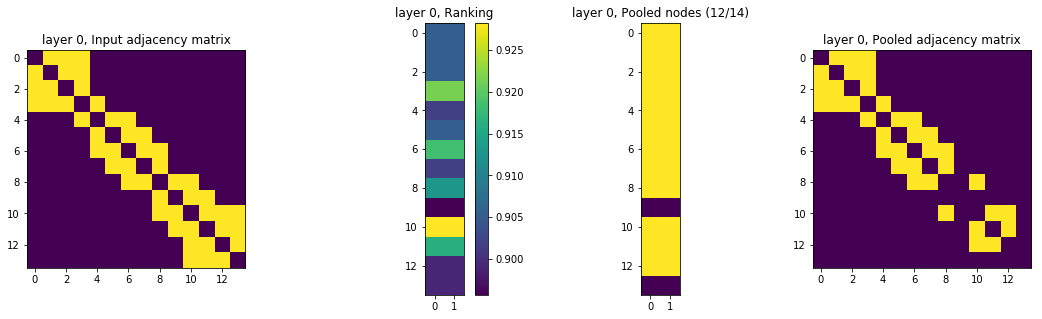

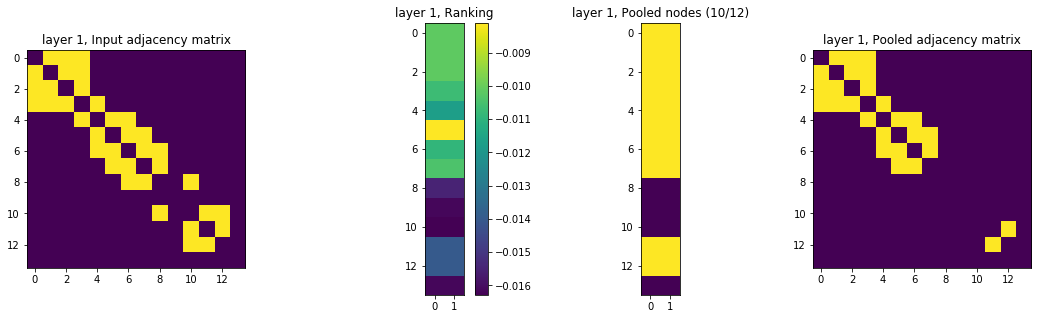

Train Epoch: 0 [32/1001 (3%)]	Loss: 0.677612 (avg: 0.677612) 	sec/iter: 2.2921
Train Epoch: 0 [352/1001 (34%)]	Loss: 0.696311 (avg: 0.680245) 	sec/iter: 0.7424
Train Epoch: 0 [672/1001 (66%)]	Loss: 0.649672 (avg: 0.669781) 	sec/iter: 0.6732
Train Epoch: 0 [992/1001 (97%)]	Loss: 0.618369 (avg: 0.669806) 	sec/iter: 0.6460
Train Epoch: 0 [1001/1001 (100%)]	Loss: 0.862473 (avg: 0.671538) 	sec/iter: 0.6314
Test set (epoch 0): Average loss: 0.6626, Accuracy: 597/1001 (59.64%)

Train Epoch: 1 [32/1001 (3%)]	Loss: 0.691414 (avg: 0.691414) 	sec/iter: 0.5904


KeyboardInterrupt: 

In [5]:
print('Loading data')
datareader = DataReader(data_dir='./data/%s/' % dataset.upper(),
                        rnd_state=np.random.RandomState(seed),
                        folds=n_folds,                    
                        use_cont_node_attr=False)

acc_folds = []
for fold_id in range(n_folds):
    print('\nFOLD', fold_id)
    loaders = []
    for split in ['train', 'test']:
        gdata = GraphData(fold_id=fold_id,
                             datareader=datareader,
                             split=split)

        loader = torch.utils.data.DataLoader(gdata, 
                                             batch_size=batch_size,
                                             shuffle=split.find('train') >= 0,
                                             num_workers=threads)
        loaders.append(loader)
    
    if model_name == 'gcn':
        model = GCN(in_features=loaders[0].dataset.features_dim,
                    out_features=loaders[0].dataset.n_classes,
                    n_hidden=0,
                    filters=[64,64,64],
                    dropout=0.2,
                    adj_sq=False,
                    scale_identity=False).to(device)
    elif model_name == 'unet':
        model = GraphUnet(in_features=loaders[0].dataset.features_dim,
                          out_features=loaders[0].dataset.n_classes,
                          n_hidden=0,
                          filters=[64,64,64],
                          dropout=0.2,
                          adj_sq=False,
                          scale_identity=False,
                          shuffle_nodes=shuffle_nodes,
                          visualize=visualize).to(device)
    else:
        raise NotImplementedError(model_name)

    print('\nInitialize model')
    print(model)
    c = 0
    for p in filter(lambda p: p.requires_grad, model.parameters()):
        c += p.numel()
    print('N trainable parameters:', c)

    optimizer = optim.Adam(
                filter(lambda p: p.requires_grad, model.parameters()),
                lr=lr,
                weight_decay=wdecay,
                betas=(0.5, 0.999))
    
    scheduler = lr_scheduler.MultiStepLR(optimizer, [20, 30], gamma=0.1)

    def train(train_loader):
        scheduler.step()
        model.train()
        start = time.time()
        train_loss, n_samples = 0, 0
        for batch_idx, data in enumerate(train_loader):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data[4])
            loss.backward()
            optimizer.step()
            time_iter = time.time() - start
            train_loss += loss.item() * len(output)
            n_samples += len(output)
            if batch_idx % log_interval == 0 or batch_idx == len(train_loader) - 1:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} (avg: {:.6f}) \tsec/iter: {:.4f}'.format(
                    epoch, n_samples, len(train_loader.dataset),
                    100. * (batch_idx + 1) / len(train_loader), loss.item(), train_loss / n_samples, time_iter / (batch_idx + 1) ))
    #             break 
    def test(test_loader):
        model.eval()
        start = time.time()
        test_loss, correct, n_samples = 0, 0, 0
        for batch_idx, data in enumerate(test_loader):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            output = model(data)
            loss = loss_fn(output, data[4], reduction='sum')
            test_loss += loss.item()
            n_samples += len(output)
            pred = output.detach().cpu().max(1, keepdim=True)[1]

            correct += pred.eq(data[4].detach().cpu().view_as(pred)).sum().item()

        time_iter = time.time() - start

        test_loss /= n_samples

        acc = 100. * correct / n_samples
        print('Test set (epoch {}): Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(epoch, 
                                                                                              test_loss, 
                                                                                              correct, 
                                                                                              n_samples, acc))
        return acc

    loss_fn = F.cross_entropy
    for epoch in range(epochs):
        train(loaders[0])
        acc = test(loaders[0])
    acc_folds.append(acc)

print(acc_folds)
print('{}-fold cross validation avg acc (+- std): {} ({})'.format(n_folds, np.mean(acc_folds), np.std(acc_folds)))